### SARIMA

In [3]:
#Import Required Libraries

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import itertools
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector, r, IntVector
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
import gc

#ARIMA and Time Series
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

#ARFIMA from ARCH package
from arch.univariate import ARX
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera
from scipy.stats import chi2
from scipy.stats import norm

#*** Haven't Chosen Which Ones Yet ***

Error importing in API mode: ImportError('dlopen(/opt/anaconda3/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so, 2): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: /opt/anaconda3/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: image not found')
Trying to import in ABI mode.


In [5]:
#Importing the headline CPI
df = pd.read_csv('/Users/nitaycarmi/Desktop/URSS Project/Datasets/Consumer Price Index All Items Total for United Kingdom .csv', parse_dates=['observation_date'])
df.rename(columns={'observation_date': 'Date', 'GBRCPALTT01IXNBM': 'CPI Headline'}, inplace=True)

In [7]:
print(df.head())
print(df.info())

        Date  CPI Headline
0 1960-01-01      5.611997
1 1960-02-01      5.611997
2 1960-03-01      5.601784
3 1960-04-01      5.632423
4 1960-05-01      5.632423
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          767 non-null    datetime64[ns]
 1   CPI Headline  767 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.1 KB
None


In [9]:
#Checking for missing values in Headline CPI
df.set_index('Date', inplace=True)
print(df.isna().sum())

CPI Headline    0
dtype: int64


In [11]:
# Seasonally adjusted data
resultH = seasonal_decompose(df['CPI Headline'], model='additive', period=12)
df['CPI_seasonally_adjusted'] = df['CPI Headline'] - resultH.seasonal

In [13]:
# Stationarity Check ADF - CPI Headline
adf_resultH = adfuller(df['CPI Headline'])
print(f'ADF Statistic: {adf_resultH[0]}')
print(f'p-value: {adf_resultH[1]}')

ADF Statistic: 1.4831431701228384
p-value: 0.9974609718715096


In [15]:
# Stationarity Check KPSS - CPI Headline
kpss_stat, p_value, lags, critical_values = kpss(df['CPI Headline'], regression='c', nlags='auto')
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Number of lags: {lags}')
print(f'Critical values: {critical_values}')

KPSS Statistic: 4.352747554219699
p-value: 0.01
Number of lags: 17
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_2563/3153560118.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(df['CPI Headline'], regression='c', nlags='auto')


In [17]:
# Make sure the index is datetime — this is safe even if it already is
df.index = pd.to_datetime(df.index)

start_date = '1970-02-01'
end_date = '2023-11-01'

df_filtered = df.loc[start_date:end_date]

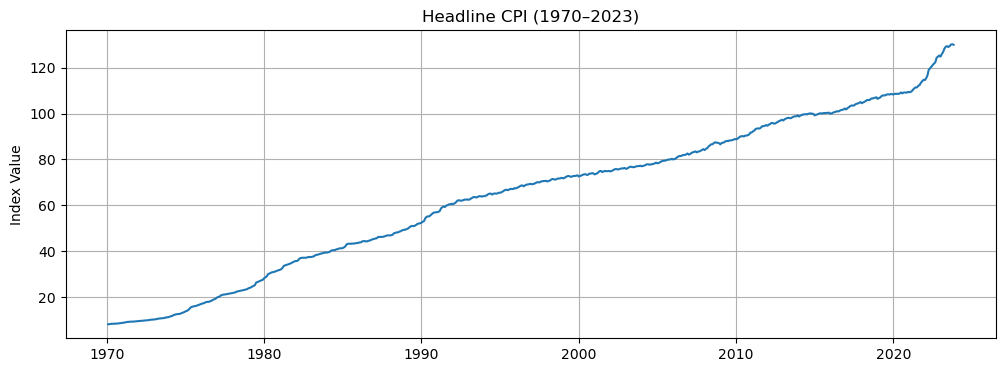

In [19]:
# Headline CPI
plt.figure(figsize=(12, 4))
plt.plot(df_filtered.index, df_filtered['CPI Headline'], label='Headline CPI')
plt.title('Headline CPI (1970–2023)')
plt.ylabel('Index Value')
plt.grid(True)
plt.show()

In [21]:
# Take the first difference and check for unit root again
df['CPI_Headline_diff'] = df['CPI Headline'].diff().dropna()
print("Headline Differenced:", adfuller(df['CPI_Headline_diff'].dropna())[1])

Headline Differenced: 0.00030343801243113284


In [23]:
# Stationarity Test - KPSS CPI Headline 1st Difference
series = df['CPI_Headline_diff'].dropna()
kpss_stat, p_value, lags, critical_values = kpss(series, regression='c', nlags='auto')
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Number of lags: {lags}')
print(f'Critical values: {critical_values}')

KPSS Statistic: 0.8714878528946634
p-value: 0.01
Number of lags: 13
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_2563/205353213.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(series, regression='c', nlags='auto')


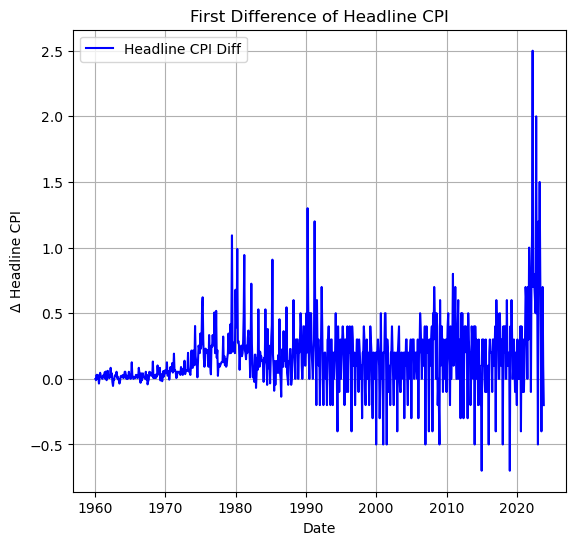

In [25]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df['CPI_Headline_diff'], color='blue', label='Headline CPI Diff')
plt.title('First Difference of Headline CPI')
plt.xlabel('Date')
plt.ylabel('Δ Headline CPI')
plt.grid(True)
plt.legend()

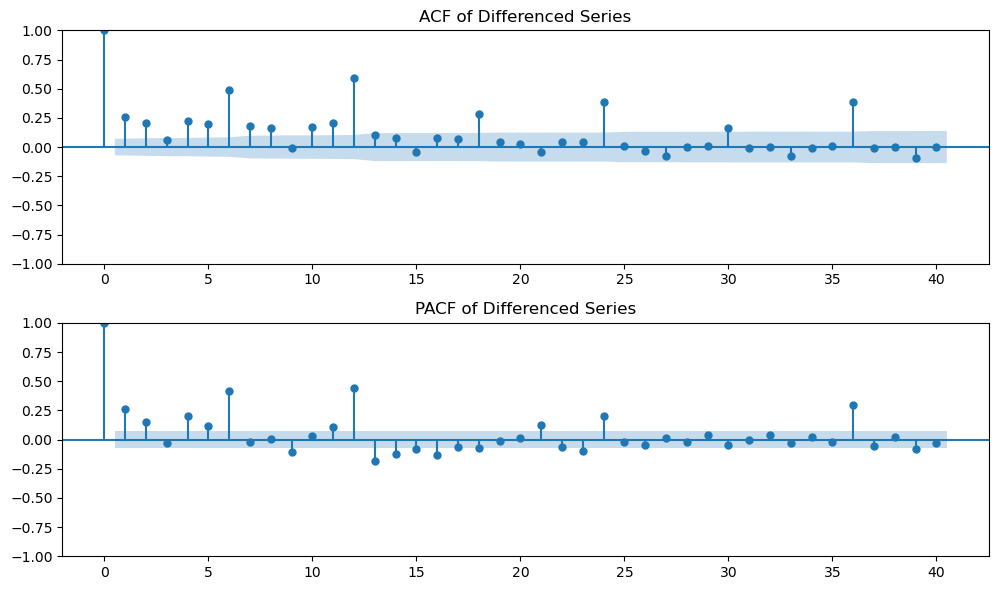

In [27]:
#Plot the ACF and PACF for the first difference of the Headline Inflation
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(df['CPI_Headline_diff'].dropna(), ax=ax[0], lags=40)
plot_pacf(df['CPI_Headline_diff'].dropna(), ax=ax[1], lags=40)

ax[0].set_title('ACF of Differenced Series')
ax[1].set_title('PACF of Differenced Series')

plt.tight_layout()
plt.show()

In [29]:
print(df['CPI_Headline_diff'].isna().sum())

1


In [31]:
series_filled = df['CPI_Headline_diff'].fillna(method='ffill')
series_no_nan = df['CPI_Headline_diff'].dropna()

/var/folders/jg/575t1x8n5_ncg5m0xf4hm2zc0000gn/T/ipykernel_2563/1747236464.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_filled = df['CPI_Headline_diff'].fillna(method='ffill')


In [33]:
model_sarima = pm.auto_arima(
    df['CPI_Headline_diff'].dropna(),     # original (non-differenced) series
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    d=1,                    # confirmed via ADF
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    D=1,                    # try 1 if you suspect seasonal differencing
    m=12,                   # seasonality (e.g. 12 months)
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print(model_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=213.387, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-123.479, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-415.352, Time=1.42 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-172.368, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-422.908, Time=2.01 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-274.543, Time=1.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-433.434, Time=2.63 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-369.057, Time=0.66 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-432.907, Time=5.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-433.176, Time=5.35 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-72.700, Time=1.76 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-431.499, Time=5.06 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=-431.511, Time=3.48 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-250.933, Time=1.96 sec
 ARIMA(1,1,2)(2,1,1)[

In [39]:
#Plot Forecast vs Test Set:
n_test = 12
train = df['CPI_Headline_diff'].dropna()[:-n_test]
test = df['CPI_Headline_diff'].dropna()[-n_test:]
n_periods = len(test)
forecast = model_sarima.predict(n_periods=n_periods)

rmse_sarima = np.sqrt(mean_squared_error(test, forecast))
mae_sarima = mean_absolute_error(test, forecast)
mape_sarima = np.mean(np.abs((test - forecast) / test)) * 100

print(f"SARIMA RMSE: {rmse_sarima:.4f}")
print(f"SARIMA MAE: {mae_sarima:.4f}")
print(f"SARIMA MAPE: {mape_sarima:.4f}")

SARIMA RMSE: 0.3953
SARIMA MAE: 0.3165
SARIMA MAPE: nan


In [41]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_pred - y_true)
    return 100 * np.mean(np.where(denominator == 0, 0, diff / denominator))

smape_val = smape(test, forecast)
print(f"sMAPE: {smape_val:.2f}%")

sMAPE: 72.12%


Why ARFIMA might be appropriate for this CPI series
From your earlier summary:

ADF test on first difference: p = 0.0003 → strongly suggests stationarity

KPSS test on first difference: statistic = 0.87 > 1% CV = 0.739 → still rejects stationarity
⚠️ Contradiction between ADF and KPSS suggests series might be fractionally integrated (i.e., 0 < d < 1)